In [ ]:
! pip install mesa

# Introduction
The tutorial model is a very simple simulated agent-based economy, drawn from econophysics and presenting a statistical mechanics approach to wealth distribution. The rules of our tutorial model:

1. There are some number of agents.
1. All agents begin with 1 unit of money.
1. At every step of the model, an agent gives 1 unit of money (if they have it) to some other agents.

Ref: Dragulescu, Adrian A., and Victor M. Yakovenko. (2002). Statistical Mechanics of Money, Income and Wealth: A Short Survey." arXiv Preprint Cond-mat/0211175.

In [11]:
from mesa import Agent
from mesa import Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid #from mesa.space import SingleGrid #한 셀에 1개의 agent만 허용
from mesa.datacollection import DataCollector
import numpy as np
import matplotlib.pyplot as plt

def compute_gini(model):
    agent_wealths=[agent.wealth for agent in model.schedule.agents]
    x=sorted(agent_wealths)
    N=model.num_agents
    B=sum(xi*(N-i) for i,xi in enumerate(x))/(N*sum(x))
    return (1+(1/N)-2*B)

class MoneyAgent(Agent):
    def __init__(self,unique_id,model):
        super().__init__(unique_id,model)
        self.wealth=1
    def step(self):
        self.move()
        if self.wealth>0:
            self.give_money()
    def move(self): #grid가 있을 때
        possible_steps=self.model.grid.get_neighborhood(
            self.pos,
            moore=True, #if False, Von Neumann(4 directions)
            include_center=False) #not self included
        new_position=self.random.choice(possible_steps) #one of neighbors
        self.model.grid.move_agent(self,new_position) #reposition
    def give_money(self):
        cellmates=self.model.grid.get_cell_list_contents([self.pos,])
        if len(cellmates) > 1:
            other=self.random.choice(cellmates)
            other.wealth+=1
            self.wealth-=1
class MoneyModel(Model):
    def __init__(self,N,model_party,width,height): #width, height는 grid에 필요하기 때문
        self.num_agents=N
        self.schedule=RandomActivation(self)
        self.grid=MultiGrid(width,height,True) #Always be toroidal? True
        for i in range(N):
            a=MoneyAgent(i,self)
            self.schedule.add(a)
            #add agent to cell
            x=self.random.randrange(self.grid.width)
            y=self.random.randrange(self.grid.height)
            self.grid.place_agent(a,(x,y,)) #지정한 coordination에 배치하고 cell에도 할당.
        self.datacollector=DataCollector(
            model_reporters={"Gini":compute_gini},
            agent_reporters={"Wealth":"wealth"})
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [23]:
model=MoneyModel(50,10,10)
for i in range(100):
    model.step()

In [3]:
%matplotlib inline

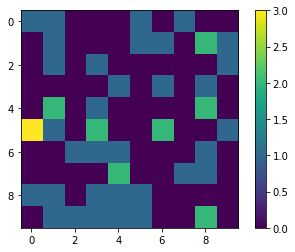

In [24]:
agent_counts=np.zeros((model.grid.width,model.grid.height))
for cell in model.grid.coord_iter():
    cell_content,x,y=cell
    agent_count=len(cell_content)
    agent_counts[x][y]=agent_count
plt.imshow(agent_counts,interpolation='nearest')
plt.colorbar()
plt.show()

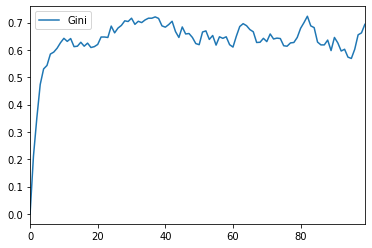

In [25]:
gini=model.datacollector.get_model_vars_dataframe()
gini.plot()

In [27]:
agent_wealth=model.datacollector.get_agent_vars_dataframe()
agent_wealth.tail()

Wealth
Step AgentID        
99   45            1
     46            0
     47            0
     48            0
     49            4

In [28]:
end_wealth=agent_wealth.xs(99,level='Step')['Wealth']

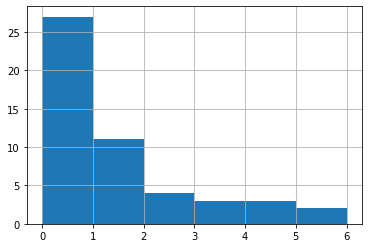

In [29]:
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

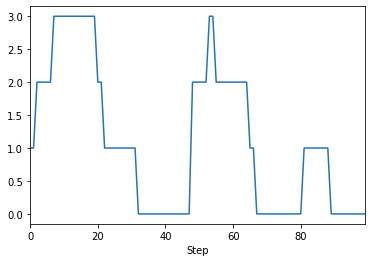

In [30]:
one_agent_wealth=agent_wealth.xs(14,level='AgentID')
one_agent_wealth.Wealth.plot()

## Batch Run
You usually won't run a model only once, but multiple times, with fixed parameters to find the overall distributions the model generates, and with varying parameters to analyze how they drive the model's outputs and behaviors. Instead of needing to write nested for-loops for each model, Mesa provides a BatchRunner class which automates it for you.

In [31]:
from mesa import Agent
from mesa import Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid #from mesa.space import SingleGrid #한 셀에 1개의 agent만 허용
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner #배치처리.
import numpy as np
import matplotlib.pyplot as plt

def compute_gini(model):
    agent_wealths=[agent.wealth for agent in model.schedule.agents]
    x=sorted(agent_wealths)
    N=model.num_agents
    B=sum(xi*(N-i) for i,xi in enumerate(x))/(N*sum(x))
    return (1+(1/N)-2*B)

class MoneyAgent(Agent):
    def __init__(self,unique_id,model):
        super().__init__(unique_id,model)
        self.wealth=1
    def step(self):
        self.move()
        if self.wealth>0:
            self.give_money()
    def move(self): #grid가 있을 때
        possible_steps=self.model.grid.get_neighborhood(
            self.pos,
            moore=True, #if False, Von Neumann(4 directions)
            include_center=False) #not self included
        new_position=self.random.choice(possible_steps) #one of neighbors
        self.model.grid.move_agent(self,new_position) #reposition
    def give_money(self):
        cellmates=self.model.grid.get_cell_list_contents([self.pos,])
        if len(cellmates) > 1:
            other=self.random.choice(cellmates)
            other.wealth+=1
            self.wealth-=1
class MoneyModel(Model):
    def __init__(self,N,width,height): #width, height는 grid에 필요하기 때문
        self.num_agents=N
        self.schedule=RandomActivation(self)
        self.grid=MultiGrid(width,height,True) #Always be toroidal? True
        self.running=True #Batch Model에서 필요하다.
        for i in range(N):
            a=MoneyAgent(i,self)
            self.schedule.add(a)
            #add agent to cell
            x=self.random.randrange(self.grid.width)
            y=self.random.randrange(self.grid.height)
            self.grid.place_agent(a,(x,y,)) #지정한 coordination에 배치하고 cell에도 할당.
        self.datacollector=DataCollector(
            model_reporters={"Gini":compute_gini},
            agent_reporters={"Wealth":"wealth"})
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [33]:
fixed_params={'width':10,'height':10}
variable_params={'N':range(10,500,10)}
batch_run=BatchRunner(
    MoneyModel,
    variable_params, #세팅의 수는 49개 range(10,500,10), 10에서 490까지
    fixed_params,
    iterations=5, #동일한 세팅을 몇 번 반복할까? 49*5=245회의 시뮬레이션 수행
    max_steps=100,
    model_reporters={'Gini':compute_gini}
)
batch_run.run_all()

245it [05:27,  2.84s/it]


Notice that each row is a model run, and gives us the parameter values associated with that run. We can use this data to view a scatter-plot comparing the number of agents to the final Gini.

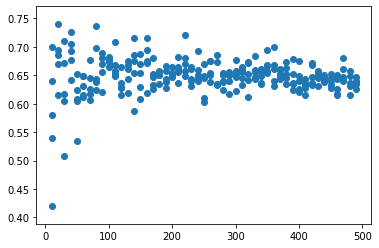

In [34]:
run_data=batch_run.get_model_vars_dataframe() #각각의 batch가 끝날 때 데이터 수집
run_data.head()
plt.scatter(run_data.N,run_data.Gini)